In [28]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
from dotenv import load_dotenv

In [29]:
def pretty_print_response(response):
    """
    This function formats a JSON file to pretty printing it in the screen.
    """
    print(json.dumps(response, indent=4, sort_keys=True))

In [30]:
PLAID_CLIENT_ID = '5f1f7eccf70dde0011538aa2'
PLAID_SECRET = '943331c353cb0e1f3880d70ff2d58d'

In [31]:
# CREATE CLIENT

In [32]:
INSITUTION_ID = "ins_109508"

In [33]:
Client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SECRET, environment='sandbox')

In [34]:
# GENERATE PUBLIC TOKEN

In [35]:
create_tkn_response = Client.Sandbox.public_token.create(INSITUTION_ID, ['transactions','income','assets'])

In [36]:
create_tkn_response

{'public_token': 'public-sandbox-c5f847c3-77f9-4f13-ae6e-af909b12edf8',
 'request_id': '6Q1zwwt2n5XNmoM'}

In [37]:
# EXCHANGE PUBLIC TOKEN FOR ACCESS TOKEN

In [38]:
exchange_response = Client.Item.public_token.exchange(create_tkn_response['public_token'])

In [39]:
access_token = exchange_response['access_token']

In [40]:
# FETCH ACCOUNTS

In [41]:
Client.Accounts.get(access_token)

{'accounts': [{'account_id': 'EMLvXq7BvJCj64nAv41EfBdZwVz1KgCXxwADX',
   'balances': {'available': 100,
    'current': 110,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '0000',
   'name': 'Plaid Checking',
   'official_name': 'Plaid Gold Standard 0% Interest Checking',
   'subtype': 'checking',
   'type': 'depository'},
  {'account_id': 'W6Bzn1Jyz3idpMEQ7MVnhAaWdDq7pwSlZrNL6',
   'balances': {'available': 200,
    'current': 210,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '1111',
   'name': 'Plaid Saving',
   'official_name': 'Plaid Silver Standard 0.1% Interest Saving',
   'subtype': 'savings',
   'type': 'depository'},
  {'account_id': 'A7opXD1kpJTaBPnJbPkvcwzAE4pe1au1r7VG4',
   'balances': {'available': None,
    'current': 1000,
    'iso_currency_code': 'USD',
    'limit': None,
    'unofficial_currency_code': None},
   'mask': '2222',
   'name': 'Plaid CD',
   'officia

In [42]:
# FETCH TRANSACTIONS FOR LAST 90  DAYS

In [43]:
start_date = '{:2020-04-28}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:2020-07-28}'.format(datetime.datetime.now())

transaction_response = Client.Transactions.get(access_token,start_date,end_date)
transactions = transaction_response['transactions']
pretty_print_response(transactions)

[
    {
        "account_id": "EMLvXq7BvJCj64nAv41EfBdZwVz1KgCXxwADX",
        "account_owner": null,
        "amount": 6.33,
        "authorized_date": null,
        "category": [
            "Travel",
            "Taxi"
        ],
        "category_id": "22016000",
        "date": "2020-07-27",
        "iso_currency_code": "USD",
        "location": {
            "address": null,
            "city": null,
            "country": null,
            "lat": null,
            "lon": null,
            "postal_code": null,
            "region": null,
            "store_number": null
        },
        "merchant_name": "Uber",
        "name": "Uber 072515 SF**POOL**",
        "payment_channel": "in store",
        "payment_meta": {
            "by_order_of": null,
            "payee": null,
            "payer": null,
            "payment_method": null,
            "payment_processor": null,
            "ppd_id": null,
            "reason": null,
            "reference_number": null
        },

In [44]:
# PRINT CATEGORIES FOR EACH TRANSACTION

In [45]:
for transaction in transactions:
    print(transaction["category"])

['Travel', 'Taxi']
['Food and Drink', 'Restaurants']
['Payment']
['Food and Drink', 'Restaurants', 'Fast Food']
['Shops', 'Sporting Goods']
['Payment', 'Credit Card']
['Travel', 'Taxi']
['Transfer', 'Debit']
['Transfer', 'Deposit']
['Recreation', 'Gyms and Fitness Centers']
['Travel', 'Airlines and Aviation Services']
['Food and Drink', 'Restaurants', 'Fast Food']
['Food and Drink', 'Restaurants', 'Coffee Shop']
['Food and Drink', 'Restaurants']
['Transfer', 'Credit']
['Travel', 'Airlines and Aviation Services']


In [46]:
# CREATE NEW DATAFRAME USING JSON

In [47]:
transactions_df = pd.DataFrame(columns=["Date", "Name", "Amount", "Category"])
dates, names, amounts, cats = [],[],[],[]
for transaction in transactions:
    dates.append(transaction["date"])
    names.append(transaction["name"])
    amounts.append(float(transaction["amount"]))
    cats.append(transaction["category"][0])
transactions_df["Date"] = dates
transactions_df["Name"] = names
transactions_df["Amount"] = amounts
transactions_df["Category"] = cats
transactions_df.tail()

,Date,Name,Amount,Category
11,2020-07-11,McDonald's,12.00,Food and Drink
12,2020-07-11,Starbucks,4.33,Food and Drink
13,2020-07-10,SparkFun,89.40,Food and Drink
14,2020-07-09,INTRST PYMNT,-4.22,Transfer
15,2020-06-29,United Airlines,500.00,Travel


In [48]:
# CONVERT DATA TYPES TO APPROPRIATE TYPES

In [49]:
transactions_df.set_index(pd.DatetimeIndex(transactions_df['Date']), inplace = True)
transactions_df.head()
transactions_df.drop(columns = ['Date'], inplace = True)
transactions_df.tail()

,Name,Amount,Category
Date,,,
2020-07-11,McDonald's,12.00,Food and Drink
2020-07-11,Starbucks,4.33,Food and Drink
2020-07-10,SparkFun,89.40,Food and Drink
2020-07-09,INTRST PYMNT,-4.22,Transfer
2020-06-29,United Airlines,500.00,Travel


In [50]:
# INCOME ANALYSIS

In [51]:
income_response = Client.Income.get(access_token)

print(income_response['income'])

last_year_gross_income = income_response["income"]["last_year_income_before_tax"]
print(f"Last years gross income was: ${last_year_gross_income}")

monthly_income = income_response["income"]["income_streams"][0]["monthly_income"]
print(f"Monthly income is: ${monthly_income}")

projected_yearly_income = income_response["income"]["projected_yearly_income"]
print(f"Projected yearly income is: ${projected_yearly_income}")

{'income_streams': [{'confidence': 0.99, 'days': 690, 'monthly_income': 500, 'name': 'UNITED AIRLINES'}], 'last_year_income': 6000, 'last_year_income_before_tax': 7285, 'max_number_of_overlapping_income_streams': 1, 'number_of_income_streams': 1, 'projected_yearly_income': 6085, 'projected_yearly_income_before_tax': 7389}
Last years gross income was: $7285
Monthly income is: $500
Projected yearly income is: $6085


In [52]:
# BUDGET ANALYSIS

In [53]:
expenses_by_cat = transactions_df.groupby('Category').sum()
expenses_by_cat

,Amount
Category,
Food and Drink,1105.73
Payment,2103.50
Recreation,78.50
Shops,500.00
Transfer,6845.78
Travel,11.73


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002103EFE9A88>],
      dtype=object)

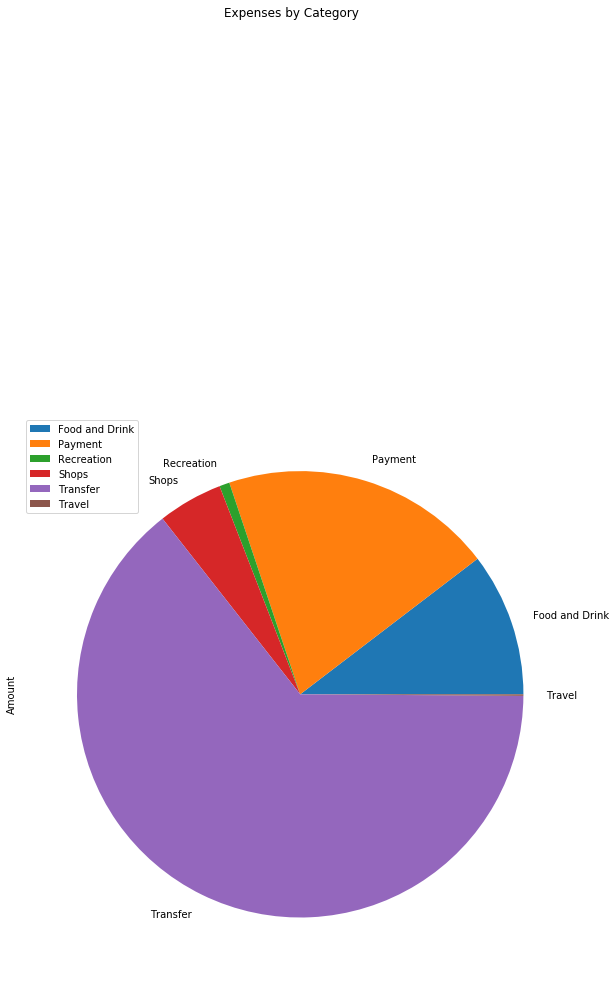

In [54]:
expenses_by_cat.plot(kind = "pie", subplots = True, title = "Expenses by Category", figsize = (10,20))

In [ ]:
# CALCULATE EXPENSES PER MONTH

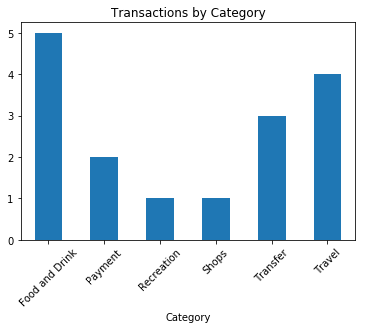

In [55]:
transactions_by_month = transactions_df.groupby('Category').count()
transactions_by_month['Amount'].plot(kind='bar', title = "Transactions by Category", rot = 45)

In [56]:
transactions_per_month = transactions_df.groupby(transactions_df.index.month).sum()
transactions_per_month

,Amount
Date,
6,500.00
7,10145.24


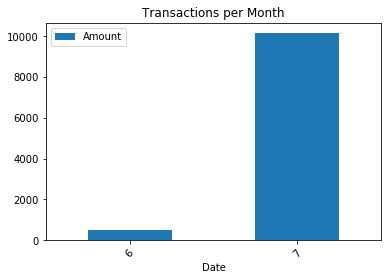

In [57]:
transactions_per_month.plot(kind = 'bar', title = "Transactions per Month", rot=45)

In [ ]:
# FIN